In [61]:
import os
import pandas as pd
from keras.preprocessing.image import img_to_array, load_img, array_to_img
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [62]:
train_dir = '../input/train/'
test_dir = '../input/test/'
categories_list = os.listdir(train_dir)
num_categories = len(categories_list)
seed = 1987
sample_per_category = 20

In [63]:
def ps_load_data(train_dir, test_dir, sample_per_category, categories_list):
    test_figs_list = os.listdir(test_dir)
    test_figs_df = pd.DataFrame(test_figs_list, columns=['file'])
    test_figs_df['file'] = test_dir + test_figs_df['file']

    train_figs_list = []
    for category_id, category in enumerate(categories_list):
        for file in os.listdir(train_dir + category + '/'):
            train_figs_list.append([train_dir + '{}/{}'.format(category, file),
                                    category_id, category])
    train_figs_df = pd.DataFrame(train_figs_list, columns=['file', 'category_id', 'category'])

    train_sample_figs_list = []
    for category_id, category in enumerate(categories_list):
        for file in os.listdir(train_dir + category + '/')[:sample_per_category]:
            train_sample_figs_list.append([train_dir + '{}/{}'.format(category, file),
                                           category_id, category])
    train_sample_figs_df = pd.DataFrame(train_sample_figs_list,
                                        columns=['file', 'category_id', 'category'])

    return train_figs_df, train_sample_figs_df, test_figs_df

In [64]:
train_figs_df, train_sample_figs_df, test_figs_df = ps_load_data(train_dir,
                                                                 test_dir,
                                                                 sample_per_category,
                                                                 categories_list)

In [65]:
print(train_figs_df.columns, train_figs_df.shape)
print(train_sample_figs_df.columns, train_sample_figs_df.shape)
print(test_figs_df.columns, test_figs_df.shape)

Index(['file', 'category_id', 'category'], dtype='object') (4750, 3)
Index(['file', 'category_id', 'category'], dtype='object') (240, 3)
Index(['file'], dtype='object') (794, 1)


In [66]:
train_figs_df.head()

,file,category_id,category
0,../input/train/Fat Hen/6b175ade7.png,0,Fat Hen
1,../input/train/Fat Hen/f0dbc5e1e.png,0,Fat Hen
2,../input/train/Fat Hen/70f84707a.png,0,Fat Hen
3,../input/train/Fat Hen/5298e390e.png,0,Fat Hen
4,../input/train/Fat Hen/5f6634fa4.png,0,Fat Hen


In [67]:
train_sample_figs_df.head()

,file,category_id,category
0,../input/train/Fat Hen/6b175ade7.png,0,Fat Hen
1,../input/train/Fat Hen/f0dbc5e1e.png,0,Fat Hen
2,../input/train/Fat Hen/70f84707a.png,0,Fat Hen
3,../input/train/Fat Hen/5298e390e.png,0,Fat Hen
4,../input/train/Fat Hen/5f6634fa4.png,0,Fat Hen


In [68]:
test_figs_df.head()

,file
0,../input/test/bf66b9cd2.png
1,../input/test/f4e7733d4.png
2,../input/test/aad8375e0.png
3,../input/test/c10ccbd82.png
4,../input/test/bdde957ec.png


In [69]:
def ps_show_train_images(df, num_imgs=3):
    random_idx = np.random.choice(np.arange(0, df.shape[0]), num_imgs**2, replace=False)
    f, axarr = plt.subplots(nrows=num_imgs, ncols=num_imgs, figsize=(13, 13))
    for i in range(num_imgs):
        for j in range(num_imgs):
            idx = random_idx[i*num_imgs + j]
            path = df.iloc[idx, 0]
            img = load_img(path, target_size=(299, 299))
            axarr[i, j].imshow(img)
            axarr[i, j].set_title(df.iloc[idx, 2])
    plt.show()

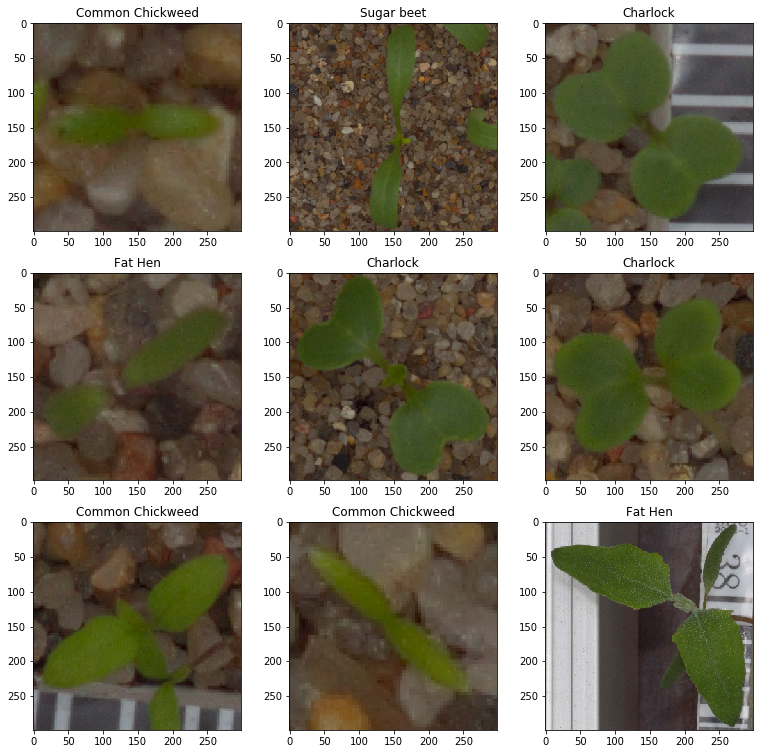

In [70]:
ps_show_train_images(train_figs_df)

In [71]:
def create_mask_for_plant(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    sensitivity = 35
    lower_hsv = np.array([60 - sensitivity, 100, 50])
    upper_hsv = np.array([60 + sensitivity, 255, 255])

    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask

def segment_plant(image):
    mask = create_mask_for_plant(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output

def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp

In [72]:
def ps_show_filter_results(df):
    f, axarr = plt.subplots(2, 2, figsize=(20, 20))
    idx = np.random.randint(0, df.shape[0])
    path = df.iloc[idx, 0]
#     img = load_img(path, target_size=(299, 299))
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    print(img.shape)
    img_mask = create_mask_for_plant(img)
    print(img_mask.shape)
    img_segmented = segment_plant(img)
    print(img_segmented.shape)
    img_sharpen = sharpen_image(img_segmented)
    print(img_sharpen.shape)
    img_resized = cv2.resize(img_sharpen, (299, 299))
    print(img_resized.shape)
    axarr[0, 0].imshow(img)
    axarr[0, 0].set_title(df.iloc[idx, 2])
    axarr[0, 1].imshow(img_mask)
    axarr[0, 1].set_title('mask')
    axarr[1, 0].imshow(img_segmented)
    axarr[1, 0].set_title('segmented')
    axarr[1, 1].imshow(img_sharpen)
    axarr[1, 1].set_title('sharpened')
    plt.show()

(94, 94, 3)
(94, 94)
(94, 94, 3)
(94, 94, 3)
(299, 299, 3)


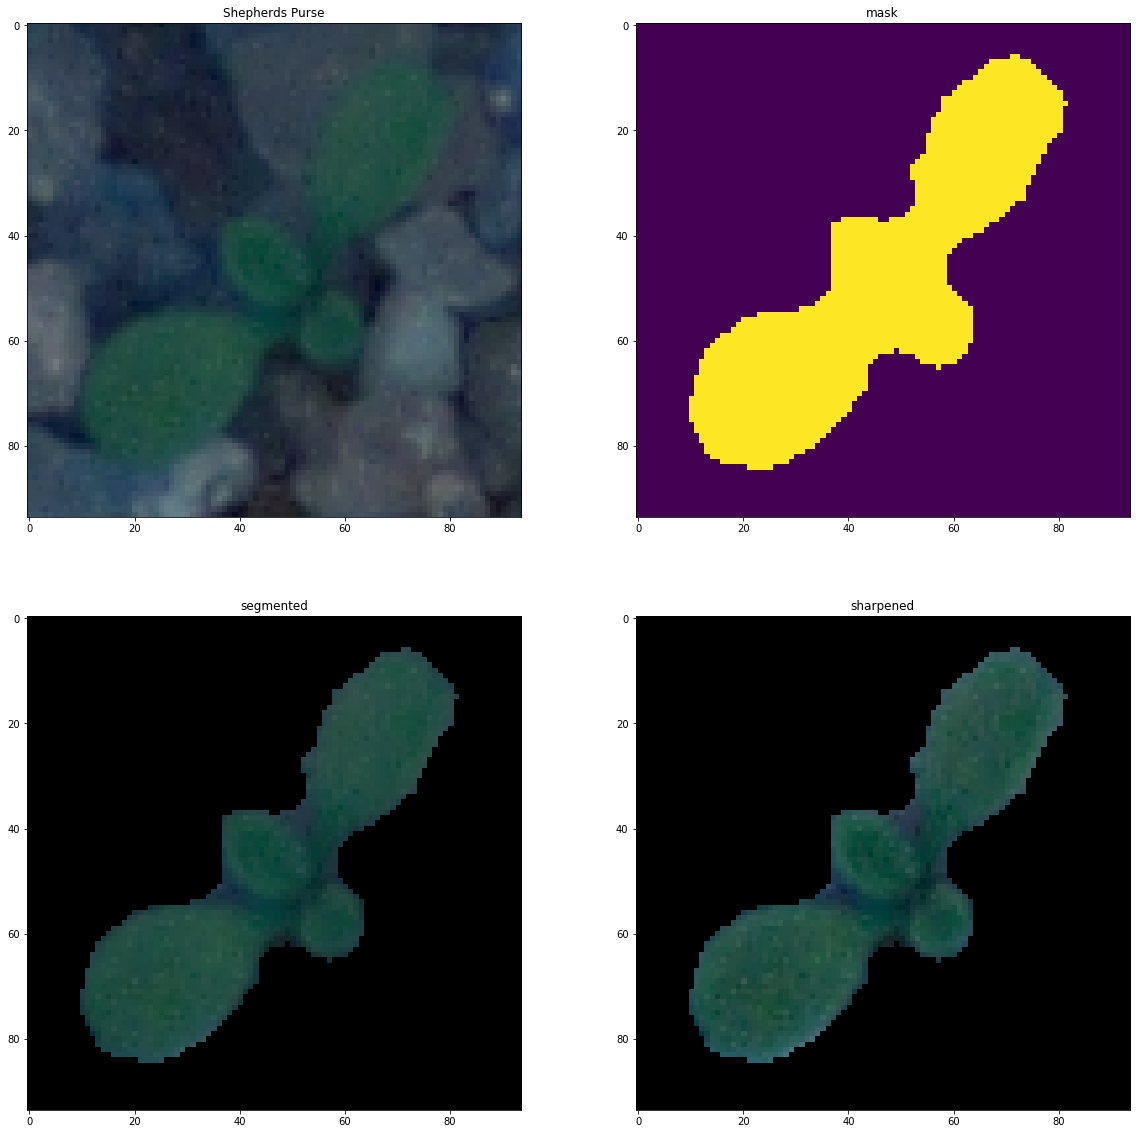

In [73]:
ps_show_filter_results(train_figs_df)

(515, 515, 3)
(515, 515)
(515, 515, 3)
(515, 515, 3)
(299, 299, 3)


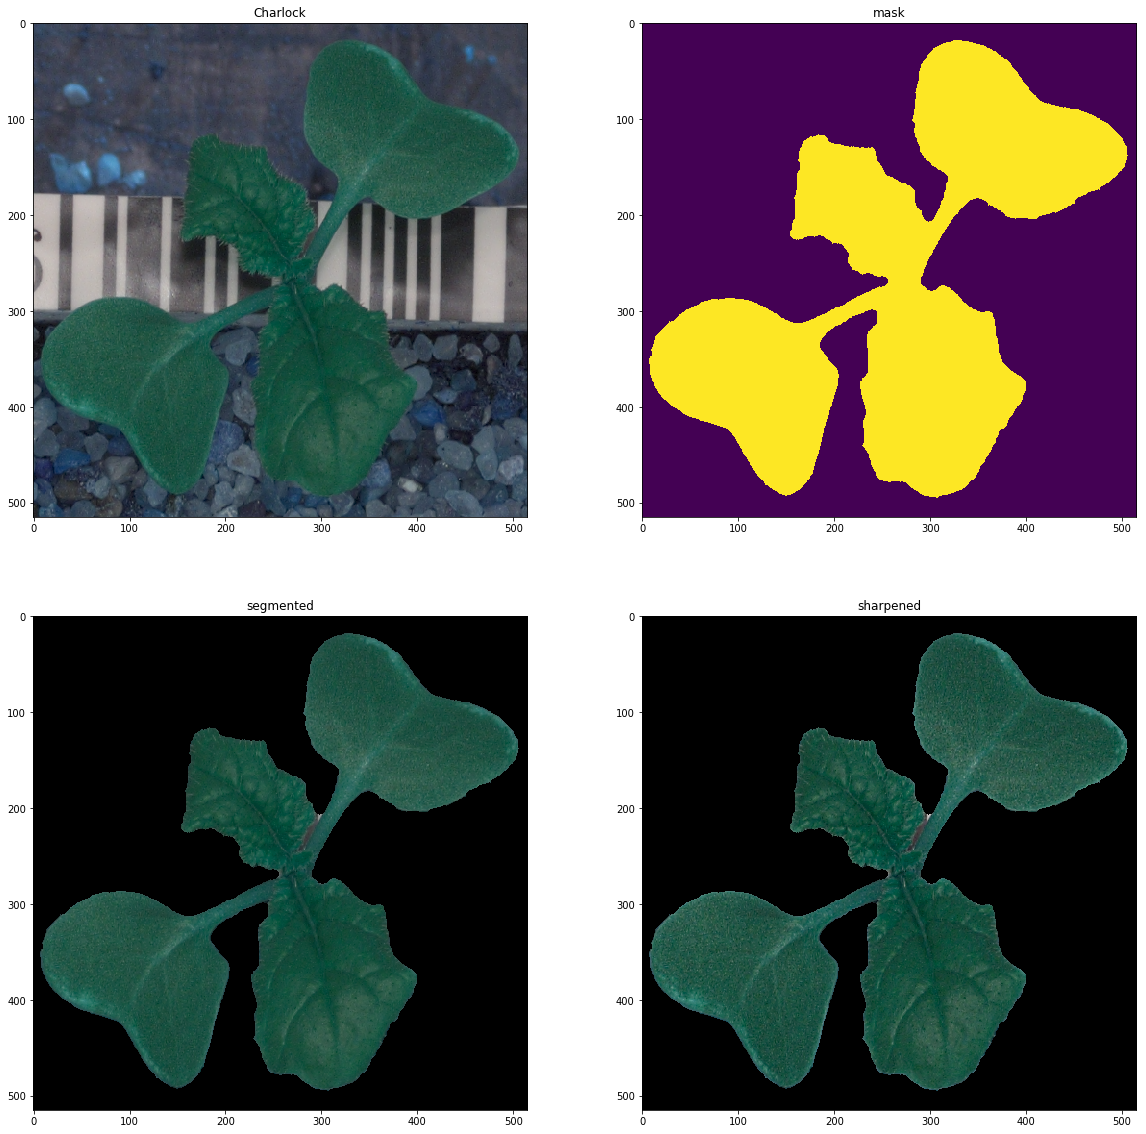

In [74]:
ps_show_filter_results(train_figs_df)

(151, 151, 3)
(151, 151)
(151, 151, 3)
(151, 151, 3)
(299, 299, 3)


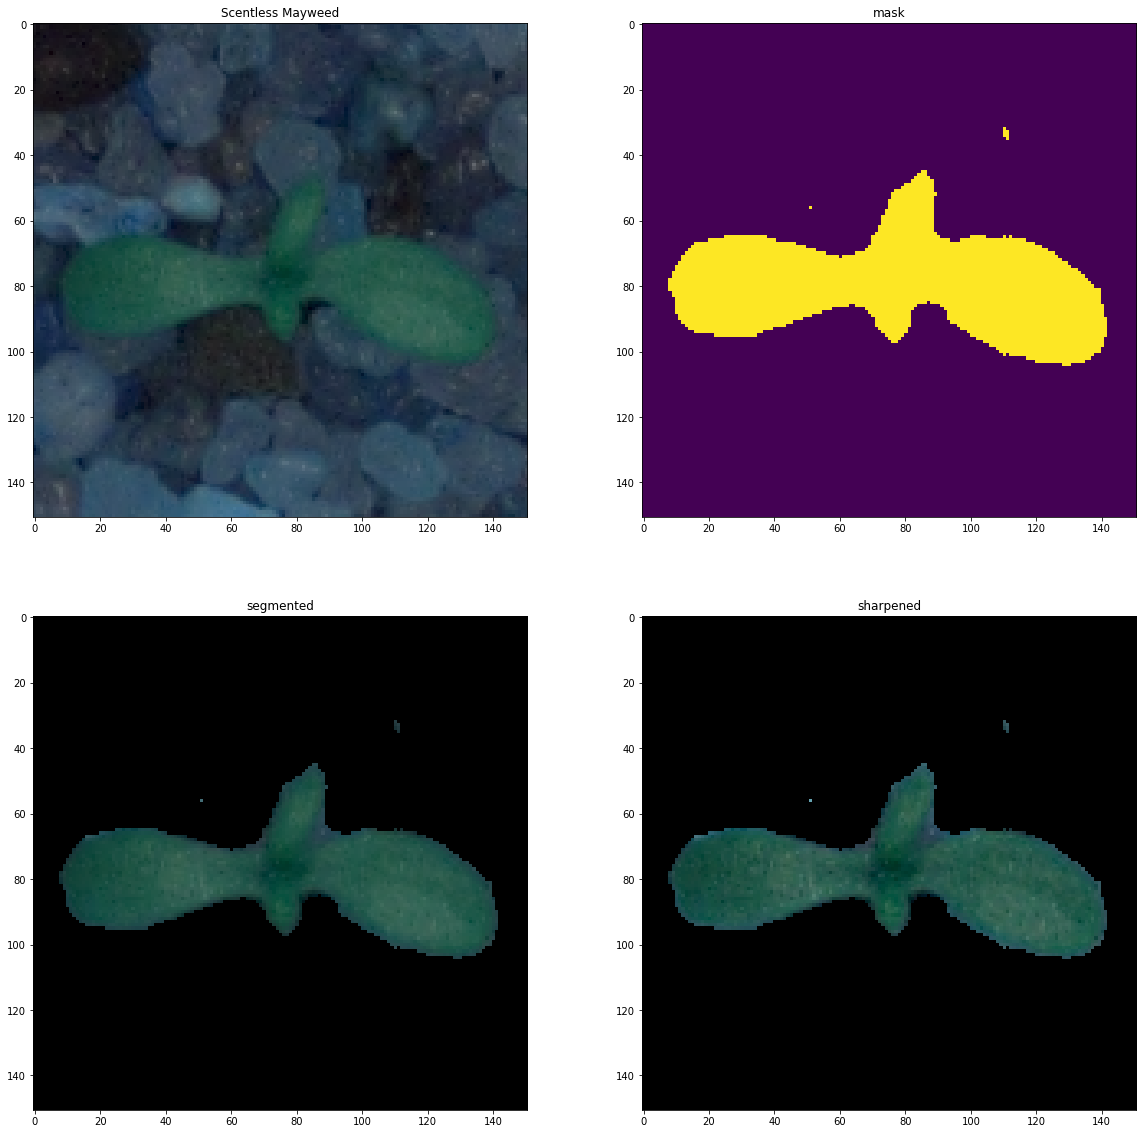

In [75]:
ps_show_filter_results(train_figs_df)